# Synthetic data test
This notebook was used to perform tests for the synthetic data generation.  
**Note that there are a lot of hard coded numbers below. They are/have been empirically tuned by visual comparison to real data.**  
Steps:
  1. Add neurons as gaussians (foreground)
  2. Deform image (warping, different shapes, translation, etc.)
     * Sample from warped neurons to get pixelated aspect
  3. Add background noise

In [1]:
%matplotlib inline

import os, sys, time, pickle
import warnings
import math
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, measure, draw, exposure, filters, feature
from skimage import morphology as morph
from scipy import stats, special, signal
from scipy import ndimage as ndi
from scipy.stats import multivariate_normal, entropy, norm
from scipy.special import gamma, digamma, polygamma
from imgaug import augmenters as iaa

# Add parent folder to path in order to access `axoid`
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from axoid.utils.image import imread_to_float, overlay_mask, to_npint
from axoid.utils.processing import flood_fill

%load_ext autoreload
%autoreload 2

In [2]:
shape = (256, 256)
laser_gain = 0.0 # from 0 to 1 <=> low to high laser gain
cyan_gcamp = True # choose if GCaMP signal will be displayed in cyan (or green by default)
return_label = True # if true will return labels instead of segmentation, 1 number per neuron

GAIN_T = 0.5 # threshold after which saturation starts to occur

if return_label:
    seg_cmap = matplotlib.cm.get_cmap("viridis")
    seg_cmap.set_under([0,0,0])
else:
    seg_cmap = "gray"

# True data statistics
  1. Compute array of pixels intensity based on background/foreground segmentation
  2. Compute intensity statistics about ROIs

In [5]:
with open("../axoid/detection/synthetic/stats_190221.pkl", "rb") as f:
    pixel_bkg, roi_max = pickle.load(f)
        
# Following are probability for bkg, simply hist/hist.sum()
p_bkg = pixel_bkg / pixel_bkg.sum(1, keepdims=True)

# Following are for the ROI region only
p_roi_max = roi_max / roi_max.sum(1, keepdims=True)

# Some pre-computed statistics
print(pixel_bkg[0].sum(), "background pixels")
print("ROI (averaged through %d ROIs):" % np.sum(roi_max))
print(" - R max =", np.sum(roi_max[0] * np.linspace(0, 1, 256) / roi_max[0].sum()))
print(" - G max =", np.sum(roi_max[1] * np.linspace(0, 1, 256) / roi_max[0].sum()))

3836446891 background pixels
ROI (averaged through 848948 ROIs):
 - R max = 0.6120638904694686
 - G max = 0.3796127192990965


Display them (restructure them from 256 bins to 20 for better visualization).

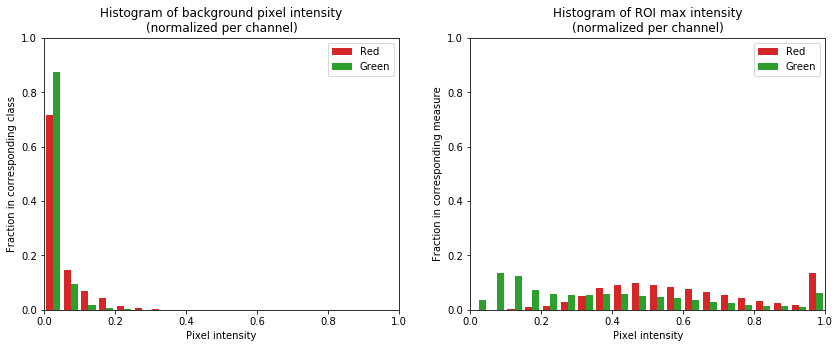

In [6]:
# Restructure the bins for plotting purposes
increment = 0.05
new_bins = np.arange(0, 1 + increment, increment)
increment_to_int = int(np.rint(255 / (new_bins.size - 1)))
new_pixel_bkg = np.zeros((2, new_bins.size - 1), dtype=np.uint32)
new_roi_max = np.zeros((2, new_bins.size - 1), dtype=np.uint32)
for i in range(new_bins.size - 1):
    new_pixel_bkg[:, i] = pixel_bkg[:, i * increment_to_int: (i + 1) * increment_to_int].sum(1)
    new_roi_max[:, i] = roi_max[:, i * increment_to_int: (i + 1) * increment_to_int].sum(1)

# Bars' parameters
ratio_bar = 0.80 # ratio of bar_width/interval_width
width = increment * ratio_bar / 2
offset_left = (increment - width) / 2
offset_right = (increment + width) / 2

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.bar(new_bins[:-1] + offset_left, new_pixel_bkg[0] / new_pixel_bkg[0].sum(), width=width, color='C3')
plt.bar(new_bins[:-1] + offset_right, new_pixel_bkg[1] / new_pixel_bkg[1].sum(), width=width, color='C2')
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histogram of background pixel intensity\n(normalized per channel)")
plt.xlabel("Pixel intensity")
plt.ylabel("Fraction in corresponding class")
plt.legend(["Red", "Green"])

plt.subplot(122)
plt.bar(new_bins[:-1] + offset_left, new_roi_max[0] / new_roi_max[0].sum(), width=width, color='C3')
plt.bar(new_bins[:-1] + offset_right, new_roi_max[1] / new_roi_max[1].sum(), width=width, color='C2')
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histogram of ROI max intensity\n(normalized per channel)")
plt.xlabel("Pixel intensity")
plt.ylabel("Fraction in corresponding measure")
plt.legend(["Red", "Green"])
plt.show()

# 1. Neurons generation

Create multiple neurons at once (as gaussian weights).

Frequency of intensity 1.0 = 0.126
Mean and std = 0.556 +- 0.180


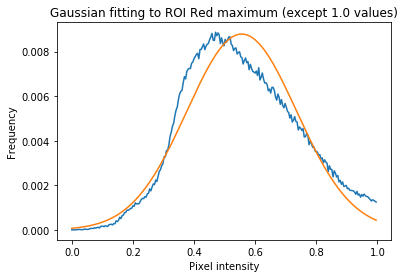

In [7]:
# Maximum ROI Red intensity fitting with Gaussian
print("Frequency of intensity 1.0 = %.3f" % p_roi_max[0][-1])

tmp_p_roi_max = p_roi_max[0].copy()[:-1]
tmp_p_roi_max /= tmp_p_roi_max.sum() # rescaling
loc = np.sum(tmp_p_roi_max * np.arange(255) / 255)
scale = np.sqrt(np.sum(tmp_p_roi_max * (np.arange(255) / 255 - loc) ** 2))
print("Mean and std = %.3f +- %.3f" % (loc, scale))
    
plt.plot(np.arange(255) / 255, tmp_p_roi_max)
gauss = norm.pdf(np.arange(255) / 255, loc=loc, scale=scale)
plt.plot(np.arange(255) / 255, gauss / gauss.sum())
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.title("Gaussian fitting to ROI Red maximum (except 1.0 values)")
plt.show()

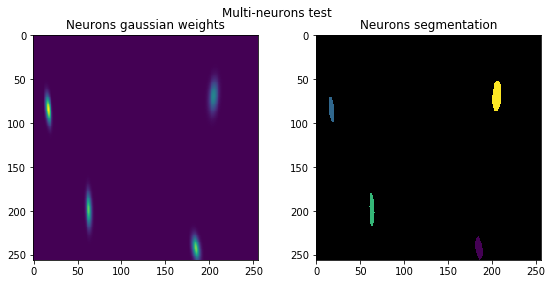

In [8]:
ellipse_size = 1.5 # factor for the ground truth ellipse (normalized by std)
n_neurons = 4
n_samples = np.random.normal(loc=1000, scale=200, size=n_neurons * 2).reshape([-1, 2])
n_samples = (n_samples + 0.5).astype(np.uint16)

means = np.zeros((n_neurons, 2))
covs = np.zeros((n_neurons, 2, 2))
if return_label:
    neurons_segs = np.zeros((n_neurons,) + shape, dtype=np.uint8)
else:
    neurons_segs = np.zeros((n_neurons,) + shape, dtype=np.bool)
contours = np.zeros((n_neurons,) + shape, dtype=np.bool)
for i in range(n_neurons):
    # Create neuron infinitly until entirely in image and no overlap with another
    # TODO: change this to something that cannot loop to infinity
    while True:
        # Mean and covariance matrix of gaussian (empirically tuned)
        # Note that x and y axes are col and row (so, inversed!)
        means[i] = np.array([np.random.randint(shape[1]), np.random.randint(shape[0])])
        scale_x = shape[1] / 64
        scale_y = shape[0] / 64
        cross_corr = np.random.randint(-2, 3) * min(scale_x, scale_y)
        covs[i] = np.array([
            [np.random.randint(1, 4) * scale_x, cross_corr],
            [cross_corr, np.random.randint(10, 40) * scale_y]
        ])
        
        # Bounding ellipses
        val, vec = np.linalg.eig(covs[i])
        rotation = math.atan2(vec[0, np.argmax(val)], vec[1, np.argmax(val)])
        rr, cc = draw.ellipse(means[i,1], means[i,0], 
                              ellipse_size * np.sqrt(val[1]), ellipse_size * np.sqrt(val[0]),
                              rotation=rotation)
        
        # Check if outside the image
        if (rr < 0).any() or (rr >= shape[0]).any() or (cc < 0).any() or (cc >= shape[1]).any():
            continue
        else:
            # Check if overlapping/touching with any existing neuron
            tmp_mask = np.zeros(shape, dtype=np.bool)
            tmp_mask[rr,cc] = 1
            if (neurons_segs[:, morph.dilation(tmp_mask)] != 0).any():
                continue
            else:
                break
                
    neurons_segs[i, rr, cc] = 1 + i * return_label
    
    tmp_contour = np.concatenate(measure.find_contours(neurons_segs[i], 0)).astype(np.int)
    contours[i, tmp_contour[:,0], tmp_contour[:,1]] = True
    

# Create gaussian weights images
rows, cols = np.arange(shape[0]), np.arange(shape[1])
grid = np.zeros(shape + (2,))
grid[:,:,0], grid[:,:,1] = np.meshgrid(cols, rows) # note the order!
neurons_gaussians = np.zeros((n_neurons,) + shape)
for i in range(n_neurons):
    neurons_gaussians[i,:,:] = multivariate_normal.pdf(grid, means[i], covs[i])
    neurons_gaussians[i,:,:] /= neurons_gaussians[i,:,:].sum()


plt.figure(figsize=(8, 4))
plt.suptitle("Multi-neurons test")
plt.subplot(121)
plt.imshow(neurons_gaussians.max(0))
plt.title("Neurons gaussian weights")
plt.subplot(122)
plt.imshow(neurons_segs.sum(0), cmap=seg_cmap, vmin=0.99)
plt.title("Neurons segmentation")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Decide which channels are present for the neurons, and what are the max values for each.

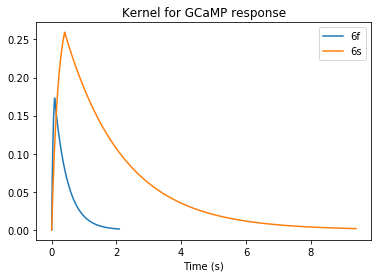

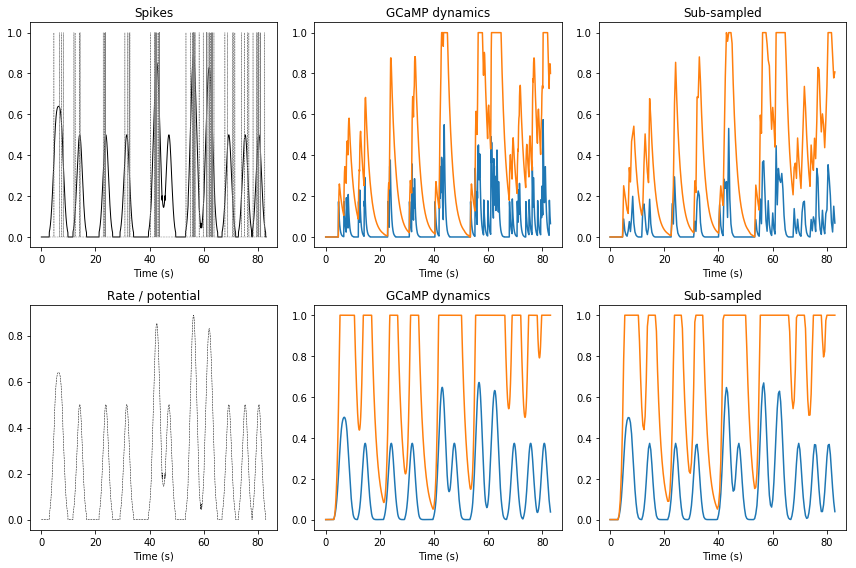

In [9]:
# Test kernels and stimuli
t = np.arange(10000) / 1000 # 10 s
# GCaMP6f
t_peak = 0.045; t_decay = 0.400; F_max = 0.20
T_peak = 2 * t_peak
idx = np.argmax(t > T_peak)
kernel_f = np.zeros(t.shape)
kernel_f[:idx] = F_max * (1 - np.exp(- t[:idx] / t_peak))
kernel_f[idx:] = F_max * np.exp(- (t[idx:] - T_peak) / t_decay) * (1 - np.exp(- t[idx] / t_peak))
kernel_f = kernel_f[:np.argmax(t > t_decay * 5 + T_peak)]
# GCaMP6s
t_peak = 0.200; t_decay = 1.800; F_max = 0.30
T_peak = 2 * t_peak
idx = np.argmax(t > T_peak)
kernel_s = np.zeros(t.shape)
kernel_s[:idx] = F_max * (1 - np.exp(- t[:idx] / t_peak))
kernel_s[idx:] = F_max * np.exp(- (t[idx:] - T_peak) / t_decay) * (1 - np.exp(- t[idx] / t_peak))
kernel_s = kernel_s[:np.argmax(t > t_decay * 5 + T_peak)]

# with open("GCaMP_kernel.pkl", "wb") as f:
#     pickle.dump((kernel_f, kernel_s), f)

# Stimuli
t = np.arange(np.rint(200/2.4) * 1000) / 1000

# Rate of firing
rate = np.zeros(len(t))
rate[np.random.randint(len(t), size=15)] = 0.5
rate = np.convolve(rate, signal.gaussian(5000, 1000), mode='full')[:len(rate)].clip(0,1)

spikes = np.random.poisson(lam=rate / 250, size=len(t)).clip(0,1)
spikes_f = np.convolve(spikes, kernel_f, mode="full")[:len(spikes)].clip(0,1)
spikes_s = np.convolve(spikes, kernel_s, mode="full")[:len(spikes)].clip(0,1)

rate_f = np.convolve(rate / 100, kernel_f, mode="full")[:len(rate)].clip(0,1)
rate_s = np.convolve(rate / 100, kernel_s, mode="full")[:len(rate)].clip(0,1)

plt.figure()
plt.title("Kernel for GCaMP response")
plt.plot(t[:len(kernel_f)], kernel_f)
plt.plot(t[:len(kernel_s)], kernel_s)
plt.xlabel("Time (s)")
plt.legend(["6f", "6s"])
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title("Spikes")
plt.plot(t, rate, '-k', linewidth=1)
plt.plot(t, spikes, '--', color='gray', linewidth=0.5)
plt.ylim(-0.05, 1.05)
plt.xlabel("Time (s)")
plt.subplot(232)
plt.title("GCaMP dynamics")
plt.plot(t, spikes_f)
plt.plot(t, spikes_s)
plt.ylim(-0.05, 1.05)
plt.xlabel("Time (s)")
plt.subplot(233)
plt.title("Sub-sampled")
plt.plot(t[::417], spikes_f[::417])
plt.plot(t[::417], spikes_s[::417])
plt.ylim(-0.05, 1.05)
plt.xlabel("Time (s)")
plt.subplot(234)
plt.title("Rate / potential")
plt.plot(t, rate, '--', color='k', linewidth=0.5)
plt.xlabel("Time (s)")
plt.subplot(235)
plt.title("GCaMP dynamics")
plt.plot(t, rate_f)
plt.plot(t, rate_s)
plt.ylim(-0.05, 1.05)
plt.xlabel("Time (s)")
plt.subplot(236)
plt.title("Sub-sampled")
plt.plot(t[::417], rate_f[::417])
plt.plot(t[::417], rate_s[::417])
plt.ylim(-0.05, 1.05)
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [10]:
channel_neurons = np.array([[True, False], [False, True], [True, True], [True, True]])
        
# GCaMP type
if np.random.rand() < 0.5: # GCaMP6f
    kernel = kernel_f
else: # GCaMP6s
    kernel = kernel_s
                            
# Random maximum sampling
max_neurons = np.zeros((n_neurons, 2))
for i in range(n_neurons):
    # Red
    if channel_neurons[i,0]:
        # First, check if 1.0, then gaussian sampling
        if np.random.rand() < p_roi_max[0][-1]:
            max_neurons[i,0] = 1.0
        else:
            tmp_p_roi_max = p_roi_max[0].copy()[:-1]
            tmp_p_roi_max /= tmp_p_roi_max.sum() # rescaling
            loc = np.sum(tmp_p_roi_max * np.arange(255) / 255)
            scale = np.sqrt(np.sum(tmp_p_roi_max * (np.arange(255) / 255 - loc) ** 2))
            max_neurons[i,0] = np.clip(np.random.normal(loc=loc, scale=scale), 0, 1)
    
    # Green
    # Fake dynamics over time, then sample from it
    if channel_neurons[i,1]:
        t = np.arange(np.rint(200/2.4) * 1000) / 1000 # in ms

        # Rate of firing
        rate = np.zeros(len(t))
        rate[np.random.randint(len(t), size=15)] = 0.5
        rate = np.convolve(rate, signal.gaussian(5000, 1000), mode='full')[:len(rate)].clip(0,1)

        # Spiking or non-spiking
        if np.random.rand() < 0.8:
            spikes = np.random.poisson(rate / 250, size=len(t)).clip(0,1)
            dynamics = np.convolve(spikes, kernel, mode="full")[:len(spikes):417]
        else:
            dynamics = np.convolve(rate / 100, kernel, mode="full")[:len(rate):417]
            
        # If no red, assures a minimum intensity
        if channel_neurons[i,0]:
            dynamics = dynamics.clip(0,1)
        else:
            dynamics = dynamics.clip(0.4,1)
        
        max_neurons[i,1] = np.random.choice(dynamics)
        
print("Max values for neurons are:")
print(max_neurons)

Max values for neurons are:
[[0.37160055 0.        ]
 [0.         0.4       ]
 [0.4678642  0.05488491]
 [0.33624806 0.00966816]]


# 2. Deformations
**Simulate the actual acquisition process**

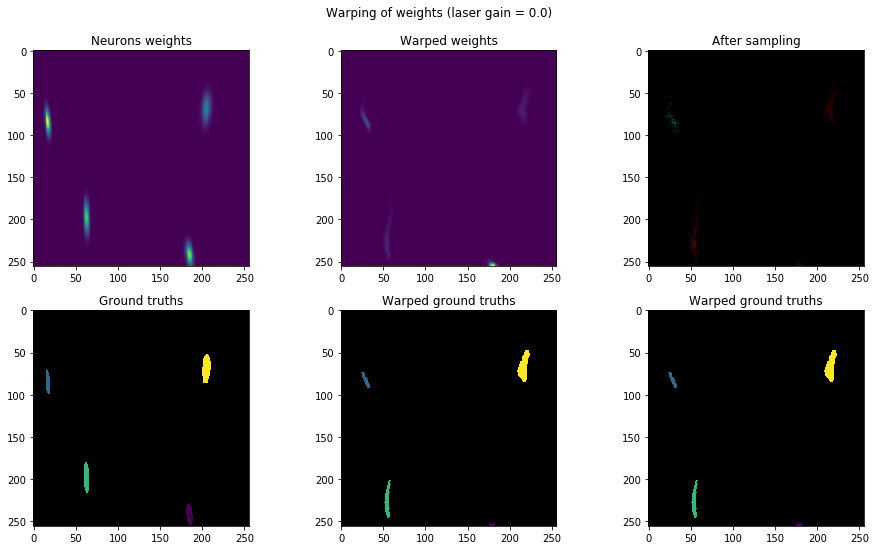

In [11]:
# Generate motions/translations
k_s = 50 # size of kernel for smoothing translations in number of rows
n_r = 0.5 # the standard deviation of the translations are 1 after n_r rows
kernel = signal.gaussian(k_s * shape[1], k_s * shape[1] / 2 ** (5/2))
kernel /= kernel.sum()
trans_row = np.cumsum(np.random.normal(0, 1 / np.sqrt(n_r * shape[1]), size=shape[0] * shape[1]))
trans_col = np.cumsum(np.random.normal(0, 1 / np.sqrt(n_r * shape[1]), size=shape[0] * shape[1]))
trans_row = np.rint(np.convolve(trans_row, kernel, mode="same").reshape(shape))
trans_col = np.rint(np.convolve(trans_col, kernel, mode="same").reshape(shape))

# Deform them like the acquisition process
wrp_gaussians = np.zeros_like(neurons_gaussians)
wrp_segs = np.zeros_like(neurons_segs)
wrp_contours = np.zeros_like(contours)
for r in range(wrp_gaussians.shape[1]):
    for c in range(wrp_gaussians.shape[2]):
        trans_r = int(r + trans_row[r,c])
        trans_c = int(c + trans_col[r,c])

        # Sample if inside the image (else, do nothing, i.e. sample zeros)
        if 0 < trans_r and trans_r < wrp_gaussians.shape[1] - 1 and \
           0 < trans_c and trans_c < wrp_gaussians.shape[2] - 1:
            wrp_gaussians[:, r, c] = neurons_gaussians[:, trans_r, trans_c]
            wrp_contours[:, r, c] = contours[:, trans_r, trans_c]
            wrp_segs[:, r, c] = neurons_segs[:, trans_r, trans_c]

for i in range(n_neurons):
    # If warping the segmentation created multiple ROIs, only keep the largest one
    labels, num = measure.label(wrp_segs[i], connectivity=1, return_num=True)
    if num > 1:
        regions = measure.regionprops(labels)
        areas = [region.area for region in regions]
        largest_label = regions[np.argmax(areas)].label
        wrp_segs[i][labels != largest_label] = 0
    # Fill the possible holes in warped segmentation
    # To avoid the case where a neuron blocks the (0,0) pixel, add fake background boundaries
    wrp_segs[i] = flood_fill(np.pad(wrp_segs[i], 1, 'constant'), fill_val=wrp_segs[i].max())[1:-1, 1:-1]
    
# Sample from weights
wrp_neurons_weight = np.zeros(shape + (3,))
for i in range(n_neurons):
    # If the neuron is outside the image, do not sample
    if wrp_segs[i].max() == 0:
        continue
    wrp_gaussians[i] /= wrp_gaussians[i].sum()
    for c in [0,1]:
        if channel_neurons[i, c] == False or max_neurons[i,c] == 0:
            continue
        # Sampling is adjusted for neuron's intensity, size, and laser gain
        if laser_gain < GAIN_T or c == 0: # low gain, no saturation nor reduced sampling
            x = np.random.choice(np.arange(wrp_neurons_weight[...,c].size), 
                                 size=int(n_samples[i,c] * max_neurons[i,c] ** 0.5 * \
                                          (np.count_nonzero(wrp_segs[i]) / 150)), 
                                 p=wrp_gaussians[i].ravel())
        else: # high gain, reduced sampling
            x = np.random.choice(np.arange(wrp_neurons_weight[...,c].size), 
                                 size=int(n_samples[i,c] * (1 - 0.5 * (laser_gain - GAIN_T) / (1 - GAIN_T)) * \
                                          max_neurons[i,c] ** 0.5 * (np.count_nonzero(wrp_segs[i]) / 150)), 
                                 p=wrp_gaussians[i].ravel())

        y, x = np.unravel_index(x, shape)
        hist = plt.hist2d(x, y, bins=[shape[1], shape[0]], range=[[0, shape[1]], [0, shape[0]]])[0]
        plt.close()

        hist = hist.T / hist.max() * \
            (max_neurons[i,c] + (1 - max_neurons[i,c]) * laser_gain / GAIN_T)
        if laser_gain >= GAIN_T: # high gain, saturation occuring
            hist = hist.clip(0, np.percentile(hist[hist > 0], 100 * (1 - (laser_gain - GAIN_T) / (1 - GAIN_T)) + \
                                                              80 * (laser_gain - GAIN_T) / (1 - GAIN_T)))
            hist /= hist.max()

        hist = hist.clip(0,1)
        wrp_neurons_weight[...,c] = np.maximum(wrp_neurons_weight[...,c], hist)

# Make GCaMP cyan if applicable
if cyan_gcamp:
    wrp_neurons_weight[...,2] = wrp_neurons_weight[...,1]
    
# Create single ground truths images
# Also make sure that touching warped neuron segmentations are separated by a border
d = []
d_l = []
for i in range(n_neurons):
    if np.count_nonzero(wrp_segs[i]) == 0:
        continue
    d.append(ndi.distance_transform_edt(wrp_segs[i]))
    d_l.append(wrp_segs[i].max())
d = np.array(d)
local_maxi = np.zeros(shape, dtype=np.uint8)
for i in range(d.shape[0]):
    r,c = np.unravel_index(np.argmax(d[i], axis=None), d[i].shape)
    local_maxi[r,c] = d_l[i]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    labels = morph.watershed(-d.max(0), local_maxi, mask=wrp_segs.max(0), watershed_line=True)
if return_label:
    wrp_segs = labels
else:
    wrp_segs = labels.astype(np.bool)

plt.figure(figsize=(13,8))
plt.suptitle("Warping of weights (laser gain = %.1f)" % laser_gain)
plt.subplot(231)
plt.title("Neurons weights")
plt.imshow(neurons_gaussians.max(0))
plt.subplot(232)
plt.title("Warped weights")
plt.imshow(wrp_gaussians.max(0))
plt.subplot(233)
plt.title("After sampling")
plt.imshow(wrp_neurons_weight)
plt.subplot(234)
plt.title("Ground truths")
plt.imshow(neurons_segs.max(0), cmap=seg_cmap, vmin=0.99)
plt.subplot(235)
plt.title("Warped ground truths")
plt.imshow(wrp_segs, cmap=seg_cmap, vmin=0.99)
plt.subplot(236)
plt.title("Warped ground truths")
plt.imshow(wrp_segs, cmap=seg_cmap, vmin=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

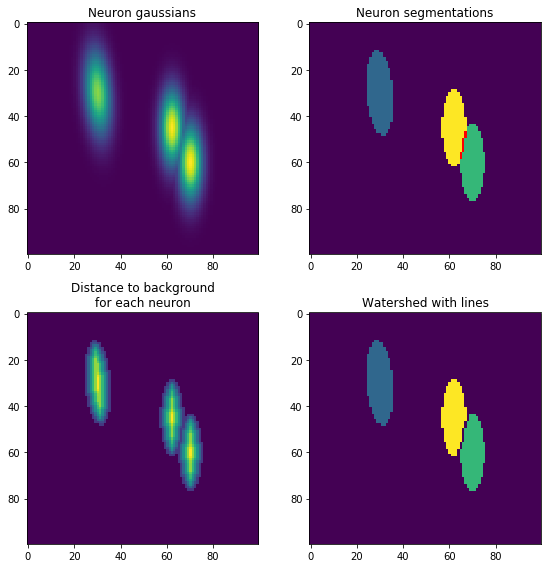

In [12]:
means = np.array([[30, 30], [70, 60], [62, 45]])
covs = np.array([[[15, 10],[10, 150]], [[12, 0],[0, 120]], [[12, 0],[0, 120]]])

# Meshgrid for the gaussian weights
rows, cols = np.arange(100), np.arange(100)
meshgrid = np.zeros((100, 100, 2))
meshgrid[:,:,0], meshgrid[:,:,1] = np.meshgrid(cols, rows) # note the order

gaus = np.zeros((3,100,100))
segs = np.zeros((3,100,100), dtype=np.uint8)
for i in range(3):
    mean = means[i]
    cov = covs[i]

    # Bounding ellipse
    val, vec = np.linalg.eig(cov)
    rotation = math.atan2(vec[0, np.argmax(val)], vec[1, np.argmax(val)])
    rr, cc = draw.ellipse(mean[1], mean[0], 
                          ellipse_size * np.sqrt(val[1]), 
                          ellipse_size * np.sqrt(val[0]),
                          rotation=rotation)
    
    segs[i, rr, cc] = 1 + i

    # Create gaussian weight image
    gaus[i,:,:] = multivariate_normal.pdf(meshgrid, mean, cov)
    gaus[i,:,:] /= gaus[i,:,:].sum()
    
d = []
d_l = []
for i in range(segs.shape[0]):
    if segs[i].sum() == 0:
        continue
    d.append(ndi.distance_transform_edt(segs[i]))
    d_l.append(segs[i].max())
d = np.array(d)
local_maxi = np.zeros((100,100), dtype=np.uint8)
for i in range(d.shape[0]):
    r,c = np.unravel_index(np.argmax(d[i], axis=None), d[i].shape)
    local_maxi[r,c] = d_l[i]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    labels = morph.watershed(-d.max(0), local_maxi, mask=segs.max(0), watershed_line=True)
segs_l = labels.astype(np.bool)

cmap = matplotlib.cm.get_cmap("viridis")
cmap.set_over([1,0,0])
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title("Neuron gaussians")
plt.imshow(gaus.max(0))
plt.subplot(222)
plt.title("Neuron segmentations")
plt.imshow(segs.sum(0), vmax=max(segs.max(), labels.max()))
plt.subplot(223)
plt.title("Distance to background\nfor each neuron")
plt.imshow(d.max(0))
plt.subplot(224)
plt.title("Watershed with lines")
plt.imshow(labels, vmax=max(segs.max(), labels.max()))
plt.tight_layout()
plt.show()

# 3. Noise

Exponential distribution for sampling the background noise.  
The mean is randomly sampled around the true mean with a small standard deviation.

E_r(X) = 0.041; STD_r(X) = 0.058
E_g(X) = 0.031; STD_g(X) = 0.029
LL_r = 2.204; LL_g = 2.477
KL_r = 0.172; KL_g = 0.558


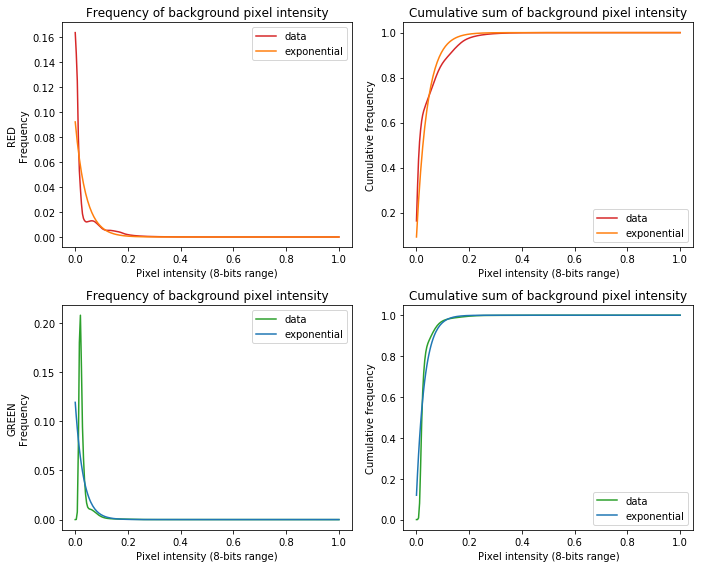

In [13]:
xx = np.arange(256) / 255
p_offset = 1E-6

print("E_r(X) = %.3f; STD_r(X) = %.3f" % \
      (np.sum(p_bkg[0] * xx), np.sqrt(np.sum(p_bkg[0] * (xx - np.sum(p_bkg[0] * xx)) ** 2))))
print("E_g(X) = %.3f; STD_g(X) = %.3f" % \
      (np.sum(p_bkg[1] * xx), np.sqrt(np.sum(p_bkg[1] * (xx - np.sum(p_bkg[1] * xx)) ** 2))))

# Exponential distribution
lambda_hat = 1 / np.sum(p_bkg * xx, 1)
p_exp = lambda_hat[:,np.newaxis] * np.exp(- lambda_hat[:,np.newaxis] * xx)
print("LL_r = %.3f; LL_g = %.3f" % (np.sum(p_bkg[0] * np.log(p_exp[0] + p_offset)),
                                    np.sum(p_bkg[1] * np.log(p_exp[1] + p_offset))))
p_exp /= p_exp.sum(1, keepdims=True)
print("KL_r = %.3f; KL_g = %.3f" % (entropy(p_bkg[0], p_exp[0]),
                                    entropy(p_bkg[1], p_exp[1])))

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(xx, p_bkg[0], "C3")
plt.plot(xx, p_exp[0], "C1")
plt.title("Frequency of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("RED\nFrequency")
plt.legend(["data", "exponential"])
plt.subplot(222)
plt.plot(xx, np.cumsum(p_bkg[0]), "C3")
plt.plot(xx, np.cumsum(p_exp[0]), "C1")
plt.title("Cumulative sum of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Cumulative frequency")
plt.legend(["data", "exponential"])
plt.subplot(223)
plt.plot(xx, p_bkg[1], "C2")
plt.plot(xx, p_exp[1], color="C0")
plt.title("Frequency of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("GREEN\nFrequency")
plt.legend(["data", "exponential"])
plt.subplot(224)
plt.plot(xx, np.cumsum(p_bkg[1]), "C2")
plt.plot(xx, np.cumsum(p_exp[1]), "C0")
plt.title("Cumulative sum of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Cumulative frequency")
plt.legend(["data", "exponential"])
plt.tight_layout()
plt.show()

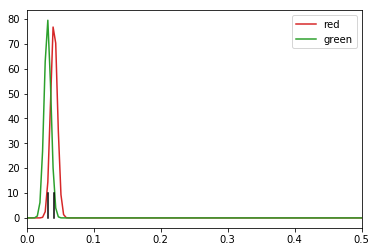

In [14]:
# Add variability to background intensity (some deviation of the mean)
plt.plot(np.arange(256)/255, 
         norm.pdf(np.arange(256)/255, 
                  loc=np.sum(p_bkg[0] * np.arange(256) / 255), scale=0.005), "C3")
plt.plot(np.arange(256)/255, 
         norm.pdf(np.arange(256)/255, 
                  loc=np.sum(p_bkg[1] * np.arange(256) / 255), scale=0.005), "C2")
plt.legend(["red", "green"])
plt.plot([np.sum(p_bkg[0] * np.arange(256) / 255), np.sum(p_bkg[0] * np.arange(256) / 255)],
         [0, 10], 'k')
plt.plot([np.sum(p_bkg[1] * np.arange(256) / 255), np.sum(p_bkg[1] * np.arange(256) / 255)],
         [0, 10], 'k')
plt.xlim(0,0.5)
plt.show()

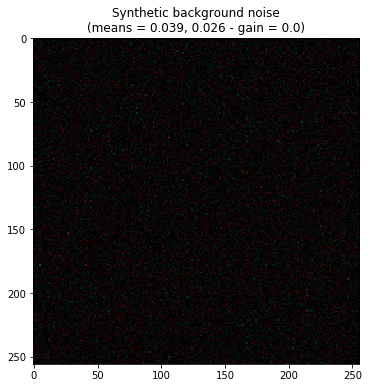

In [15]:
if laser_gain < GAIN_T: # low gain, no saturation
    noise_means = np.array([np.sum(p_bkg[0] * np.arange(256) / 255) * (1 - laser_gain) + 0.137 * laser_gain,
                            np.sum(p_bkg[1] * np.arange(256) / 255) * (1 - laser_gain) + 0.127 * laser_gain])
    noise_means = np.array([np.random.normal(loc=noise_means[0], scale=0.005),
                            np.random.normal(loc=noise_means[1], scale=0.005)])
    
    noise_red = np.random.exponential(noise_means[0], size=shape).clip(0,1)
    noise_green = (np.random.binomial(1, 1 + (0.03 - 1) * laser_gain ** 0.5, size=shape) * \
                   np.random.exponential(noise_means[1], size=shape)).clip(0,1)

else: # high gain, saturation and reduced sampling
    noise_means = np.array([np.sum(p_bkg[0] * np.arange(256) / 255) * (1 - laser_gain) + 0.137 * laser_gain,
                            (np.sum(p_bkg[1] * np.arange(256) / 255) * (1 - GAIN_T) + 0.127 * GAIN_T) * \
                            (1 - (laser_gain - GAIN_T) ** 2 / (1 - GAIN_T) ** 2) + \
                            0.411 * (laser_gain - GAIN_T) ** 2 / (1 - GAIN_T) ** 2])
    noise_means = np.array([np.random.normal(loc=noise_means[0], scale=0.005),
                            np.random.normal(loc=noise_means[1], scale=0.005)])
    
    noise_red = np.maximum(np.random.exponential(noise_means[0], size=shape),
                           np.random.binomial(1, 0.004 * (laser_gain - GAIN_T) / (1 - GAIN_T), size=shape)).clip(0,1)
    noise_green = np.maximum(np.random.binomial(1, 1 + (0.03 - 1) * laser_gain ** 0.5, size=shape) * \
                             np.random.exponential(noise_means[1], size=shape),
                             np.random.binomial(1, 0.005 * (laser_gain - GAIN_T) / (1 - GAIN_T), size=shape)).clip(0,1)

# Make GCaMP cyan if applicable
if cyan_gcamp:
    noise = np.stack([noise_red, noise_green, noise_green], -1)
else:
    noise = np.stack([noise_red, noise_green, np.zeros_like(noise_green)], -1)

plt.figure(figsize=(6,6))
plt.title("Synthetic background noise\n(means = %.3f, %.3f - gain = %.1f)" % \
          (noise_means[0], noise_means[1], laser_gain))
plt.imshow(noise, vmin=0, vmax=1)
plt.show()

# All together 

Mix background, warped neurons and background noise together. Using simple addition might causes the neurons to be too bright, so we use max().

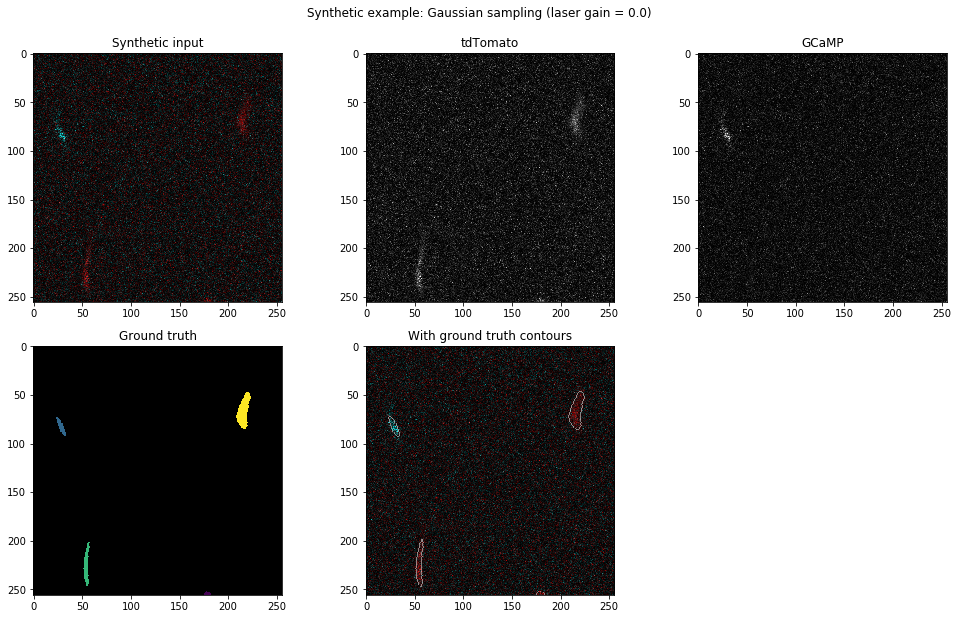

In [16]:
img_display = np.maximum(wrp_neurons_weight, noise)
for c in range(img_display.shape[-1]):
    if c == 2 and cyan_gcamp is False:
        continue
    img_display[...,c] /= img_display[...,c].max()

plt.figure(figsize=(14,9))
plt.suptitle("Synthetic example: Gaussian sampling (laser gain = %.1f)" % laser_gain)
plt.subplot(231)
plt.title("Synthetic input")
plt.imshow(img_display, vmin=0, vmax=1)
plt.subplot(232)
plt.title("tdTomato")
plt.imshow(img_display[...,0], vmin=0, vmax=1, cmap='gray')
plt.subplot(233)
plt.title("GCaMP")
plt.imshow(img_display[...,1], vmin=0, vmax=1, cmap='gray')
plt.subplot(234)
plt.title("Ground truth")
plt.imshow(wrp_segs, cmap=seg_cmap, vmin=0.99)
plt.subplot(235)
plt.title("With ground truth contours")
plt.imshow(overlay_mask(img_display, 
                        wrp_contours.sum(0), opacity=0.5 * (1 + laser_gain), mask_color=[1,1,1]))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Change laser gain
Recompute the sampling and noise for various laser gain.

In [17]:
save_gain = np.zeros((11,) + shape + (3,))

@interact(gain=widgets.FloatSlider(min=0, max=1, step=0.1, value=0, readout_format='.1f'),
          cyan=widgets.Checkbox(value=True))
def plot_various_gain(gain, cyan):
    # Sample neurons
    wrp_neurons_weight = np.zeros(shape + (3,))
    for i in range(n_neurons):
        for c in [0,1]:
            if channel_neurons[i, c] == False or max_neurons[i,c] == 0:
                continue
            if gain < GAIN_T or c == 0: # low gain, no saturation
                x = np.random.choice(np.arange(wrp_neurons_weight[...,c].size), 
                                     size=int(n_samples[i,c] * max_neurons[i,c] ** 0.5), 
                                     p=wrp_gaussians[i].ravel())
            else: # high gain, reduced sampling
                x = np.random.choice(np.arange(wrp_neurons_weight[...,c].size), 
                                     size=int(n_samples[i,c] * (1 - 0.5 * (gain - GAIN_T) / (1 - GAIN_T)) * \
                                              max_neurons[i,c] ** 0.5), 
                                     p=wrp_gaussians[i].ravel())

            y, x = np.unravel_index(x, shape)
            hist = plt.hist2d(x, y, bins=[shape[1], shape[0]], range=[[0, shape[1]], [0, shape[0]]])[0]
            plt.close()

            hist = hist.T / hist.max() * \
                (max_neurons[i,c] + (1 - max_neurons[i,c]) * gain / GAIN_T)
            if gain >= GAIN_T: # high gain, saturation occuring
                hist = hist.clip(0, np.percentile(hist[hist > 0], 100 * (1 - (gain - GAIN_T) / (1 - GAIN_T)) + \
                                                                  80 * (gain - GAIN_T) / (1 - GAIN_T)))
                hist /= hist.max()

            hist = hist.clip(0,1)
            wrp_neurons_weight[...,c] = np.maximum(wrp_neurons_weight[...,c], hist)
    
    # Sample noise
    if gain < GAIN_T: # low gain, no saturation
        noise_means = np.array([np.sum(p_bkg[0] * np.arange(256) / 255) * (1 - gain) + 0.137 * gain,
                                np.sum(p_bkg[1] * np.arange(256) / 255) * (1 - gain) + 0.127 * gain])
        noise_means = np.array([np.random.normal(loc=noise_means[0], scale=0.005),
                                np.random.normal(loc=noise_means[1], scale=0.005)])

        noise_red = np.random.exponential(noise_means[0], size=shape).clip(0,1)
        noise_green = (np.random.binomial(1, 1 + (0.03 - 1) * gain ** 0.5, size=shape) * \
                       np.random.exponential(0.03 * (1 - gain) + 0.127 * gain, size=shape)).clip(0,1)

    else: # high gain, saturation and reduced sampling
        noise_means = np.array([np.sum(p_bkg[0] * np.arange(256) / 255) * (1 - gain) + 0.137 * gain,
                                (np.sum(p_bkg[1] * np.arange(256) / 255) * (1 - GAIN_T) + 0.127 * GAIN_T) * \
                                (1 - (gain - GAIN_T) ** 2 / (1 - GAIN_T) ** 2) + \
                                0.411 * (gain - GAIN_T) ** 2 / (1 - GAIN_T) ** 2])
        noise_means = np.array([np.random.normal(loc=noise_means[0], scale=0.005),
                                np.random.normal(loc=noise_means[1], scale=0.005)])

        noise_red = np.maximum(np.random.exponential(noise_means[0], size=shape),
                               np.random.binomial(1, 0.004 * (gain - GAIN_T) / (1 - GAIN_T), size=shape)).clip(0,1)
        noise_green = np.maximum(np.random.binomial(1, 1 + (0.03 - 1) * gain ** 0.5, size=shape) * \
                                 np.random.exponential(noise_means[1], size=shape),
                                 np.random.binomial(1, 0.005 * (gain - GAIN_T) / (1 - GAIN_T), size=shape)).clip(0,1)
    
    
    # Make GCaMP cyan if applicable
    if cyan:
        wrp_neurons_weight[...,2] = wrp_neurons_weight[...,1]
        noise = np.stack([noise_red, noise_green, noise_green], -1)
    else:
        noise = np.stack([noise_red, noise_green, np.zeros_like(noise_green)], -1)
    
    # Plot
    img_display = np.maximum(wrp_neurons_weight, noise)
    for c in range(img_display.shape[-1]):
        if c == 2 and cyan is False:
            continue
        img_display[...,c] /= img_display[...,c].max()

    plt.figure(figsize=(13,9))
    plt.suptitle("Synthetic example: Gaussian sampling (laser gain = %.1f)" % gain)
    plt.subplot(231)
    plt.title("Synthetic input")
    plt.imshow(img_display, vmin=0, vmax=1)
    plt.subplot(232)
    plt.title("tdTomato")
    plt.imshow(img_display[...,0], vmin=0, vmax=1, cmap='gray')
    plt.subplot(233)
    plt.title("GCaMP")
    plt.imshow(img_display[...,1], vmin=0, vmax=1, cmap='gray')
    plt.subplot(234)
    plt.title("Ground truth")
    plt.imshow(wrp_segs, cmap=seg_cmap, vmin=0.99)
    plt.subplot(235)
    plt.title("With ground truth contours")
    plt.imshow(overlay_mask(img_display, 
                            wrp_contours.sum(0), opacity=0.5 * (1 + laser_gain), mask_color=[1,1,1]))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    save_gain[int(gain*10)] = img_display

interactive(children=(FloatSlider(value=0.0, description='gain', max=1.0, readout_format='.1f'), Checkbox(valu…

## Adjust intensity and saturation
Add some random saturation, gamma correction, etc. to simulate different laser gain and noise intensities.

gamma = 1.1537722965613981


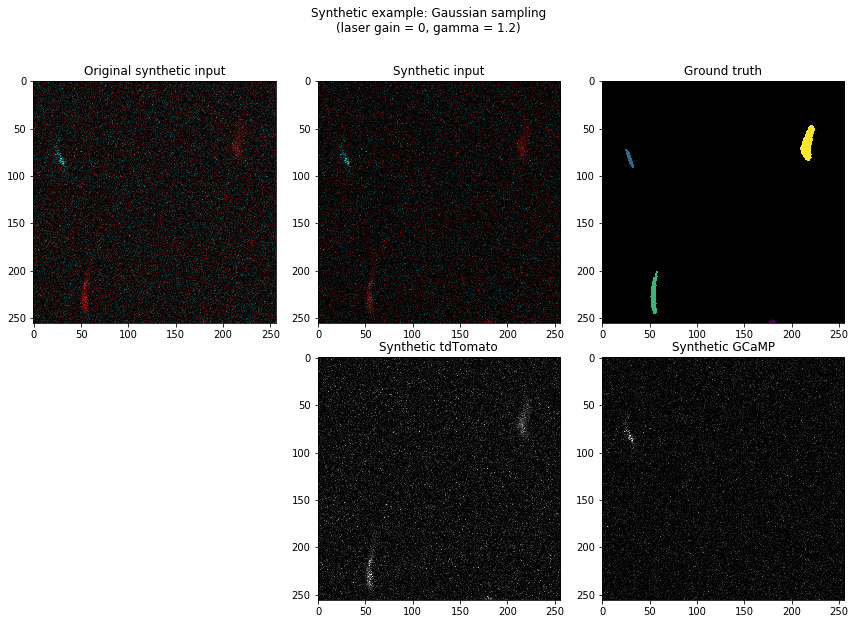

In [18]:
# Test random gamma correction
gamma = np.random.rand() * 0.6 + 0.7
print("gamma =", gamma)

img_display = np.maximum(wrp_neurons_weight, noise)
for c in range(img_display.shape[-1]):
    if c == 2 and cyan_gcamp is False:
        continue
    img_display[...,c] /= img_display[...,c].max()
    
img_display_gamma = exposure.adjust_gamma(img_display, gamma=gamma)

plt.figure(figsize=(12,9))
plt.suptitle("Synthetic example: Gaussian sampling\n(laser gain = %d, gamma = %.1f)" % (laser_gain, gamma))
plt.subplot(231)
plt.title("Original synthetic input")
plt.imshow(img_display, cmap='gray', vmin=0, vmax=1)
plt.subplot(232)
plt.title("Synthetic input")
plt.imshow(img_display_gamma, cmap='gray', vmin=0, vmax=1)
plt.subplot(233)
plt.title("Ground truth")
plt.imshow(wrp_segs, cmap=seg_cmap, vmin=0.99)
plt.subplot(235)
plt.title("Synthetic tdTomato")
plt.imshow(img_display_gamma[...,0], cmap='gray')
plt.subplot(236)
plt.title("Synthetic GCaMP")
plt.imshow(img_display_gamma[...,1], cmap='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()